In [1]:
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import AutoImageProcessor, ZoeDepthForDepthEstimation
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
image_processor = AutoImageProcessor.from_pretrained("Intel/zoedepth-nyu-kitti", use_fast=True)
model = ZoeDepthForDepthEstimation.from_pretrained("Intel/zoedepth-nyu-kitti")

In [3]:
img1 = Image.open("../data/b1.jpg")
img2 = Image.open("../data/b3.jpg")

In [4]:
inputs = image_processor(images=[img1, img2], return_tensors='pt')

In [5]:
with torch.no_grad():
    outputs = model(**inputs)

In [6]:
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    source_sizes=[(img1.height, img1.width), (img2.height, img2.width)],
)

pred_depth1 = post_processed_output[0]["predicted_depth"]
depth1 = pred_depth1 * 255 / pred_depth1.max()
depth1 = depth1.detach().cpu().numpy()
depth1 = depth1.astype("uint8")

pred_depth2 = post_processed_output[1]["predicted_depth"]
depth2 = pred_depth2 * 255 / pred_depth2.max()
depth2 = depth2.detach().cpu().numpy()
depth2 = depth2.astype("uint8")

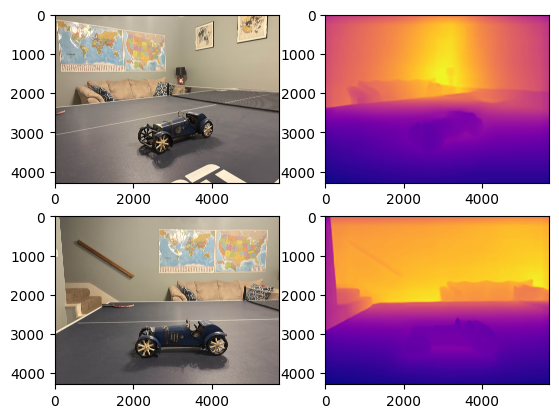

In [7]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img1)
ax[0, 1].imshow(depth1, cmap="plasma")
ax[1, 0].imshow(img2)
ax[1, 1].imshow(depth2, cmap="plasma")

In [8]:
def make_pcd(image, depth):
    w, h = image.size
    # depth_image = (output * 255 / np.max(output)).astype('uint8')

    depth_o3d = o3d.geometry.Image(depth)
    image_o3d = o3d.geometry.Image(np.array(image))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)

    cam_intrinsic = o3d.camera.PinholeCameraIntrinsic()
    cam_intrinsic.set_intrinsics(w, h, 4000, 4000, w/2, h/2)

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, cam_intrinsic)
    return pcd

In [9]:
pcd1 = make_pcd(img1, depth1)
o3d.visualization.draw_geometries([pcd1])

In [ ]:
pcd2 = make_pcd(img2, depth2)
o3d.visualization.draw_geometries([pcd2]) 
# camera intrinsics are way off?



In [ ]:
def kabsch_umeyama_matching(src, dst):
    # TMRW TODO: implement this, contribute to open3d?
    pass

In [26]:
rotation_matrix = o3d.geometry.get_rotation_matrix_from_xyz([np.pi/4, 0, 0.0])
print(type(rotation_matrix))
merged = pcd1 + pcd2.rotate(R=rotation_matrix)
o3d.visualization.draw_geometries([merged]) 

<class 'numpy.ndarray'>
